In [1]:
%pip install datasets contractions nltk transformers torch

In [2]:
import functools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import string
import contractions
import seaborn as sns
import torch
import nltk

from typing import Dict, Any, Optional, List, Tuple
from transformers import pipeline
from datasets import load_dataset
from nltk.corpus import stopwords


nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
@functools.cache
def load_data():
  """
  Avoid loading the dataset every time. Only ONCE
  """
  ds = load_dataset("dmitva/human_ai_generated_text")

  df_all = ds["train"].to_pandas()
  df_all.drop(columns=["id"],inplace=True)

  # Find out the length of ai_text and human_text
  df_all["ai_text_length"] = df_all["ai_text"].str.len()
  df_all["human_text_length"] = df_all["human_text"].str.len()

  return df_all

In [4]:
# Load the data
df = load_data()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


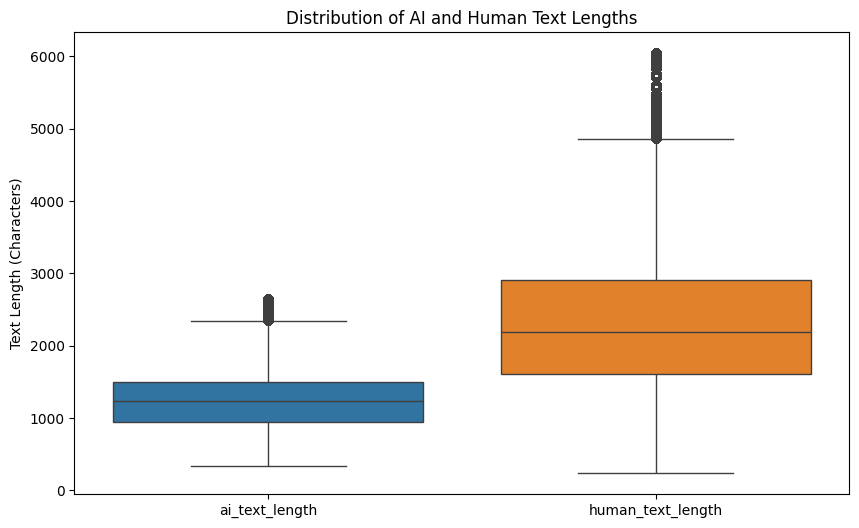

In [5]:
# prompt: For df's ai_text_length and human_text_length, draw a whisker plot for their distributions
# Create the whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['ai_text_length', 'human_text_length']])
plt.title('Distribution of AI and Human Text Lengths')
plt.ylabel('Text Length (Characters)')
plt.show()


## NLTK-based word frequency inspection

In [6]:
from collections import defaultdict
def compute_freq(col_name: Optional[str], series_inputs : pd.Series):

  col_name = "untitled" if col_name is None else col_name

  freqs = defaultdict(int)

  puncs = set(string.punctuation)
  stopwords = set(nltk.corpus.stopwords.words("english"))
  bad_tokens = {*stopwords, *puncs}

  for idx, comment in enumerate(series_inputs):
      print(f"\r[{col_name}]PROGRESS: {idx + 1} / {len(series_inputs)}", end="")

      word_tokens = nltk.word_tokenize(comment)
      filtered_sentence = [w for w in word_tokens if w not in bad_tokens]

      for word in filtered_sentence:
          if word not in freqs:
              freqs[word] = 1
          else:
              freqs[word] += 1

  # Also look at the words for expressing emotions
  pos_dict = dict(nltk.pos_tag(list(freqs.keys()), tagset="universal"))

  # now let's look at those words that can potentially suggset feelings, in this case they are adjectives, adverbs, and conjunctions
  emote_word_freqs = {
      k: v for k, v in freqs.items() if pos_dict[k] in ["ADJ", "ADV", "CONJ"]
  }

  print("\nAll Done.")


  return (dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True)),
          dict(sorted(emote_word_freqs.items(), key=lambda item: item[1], reverse=True)),)

def visualize_freq(col_name: Optional[str], freqs : Dict[str,int], emote_freqs: Dict[str,int]):

  col_name = "untitled" if col_name is None else col_name

  top_n = 50
  top_words = list(freqs.keys())[:top_n]
  top_counts = list(freqs.values())[:top_n]

  top_emo_words = list(emote_freqs.keys())[:top_n]
  top_emo_counts = list(emote_freqs.values())[:top_n]

  plt.figure(figsize=(top_n / 4, 3))
  plt.bar(top_words, top_counts, align="center")
  plt.xticks(rotation=90)
  plt.title(f"[{col_name}]Frequencies of top {top_n} words")

  plt.show()

  plt.figure(figsize=(top_n / 4, 3))
  plt.bar(top_emo_words, top_emo_counts, align="center")
  plt.xticks(rotation=90)
  plt.title(f"[{col_name}]Frequencies of top {top_n} EMOTIONAL words")

  plt.show()


def analyze(col_name: Optional[str], series_inputs : pd.Series):
  freqs, emote_freqs = compute_freq(col_name, series_inputs)
  visualize_freq(col_name, freqs, emote_freqs)

  return (freqs, emote_freqs,)


In [7]:
df_sample = df.sample(10000)

[ai_text]PROGRESS: 10000 / 10000
All Done.


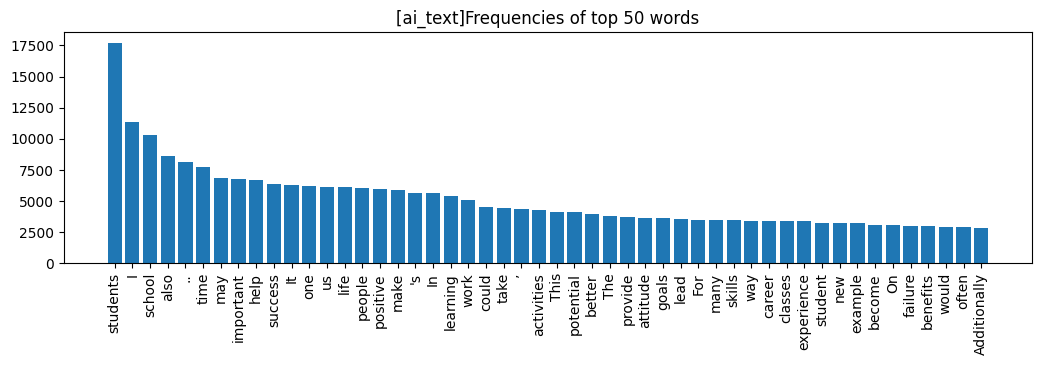

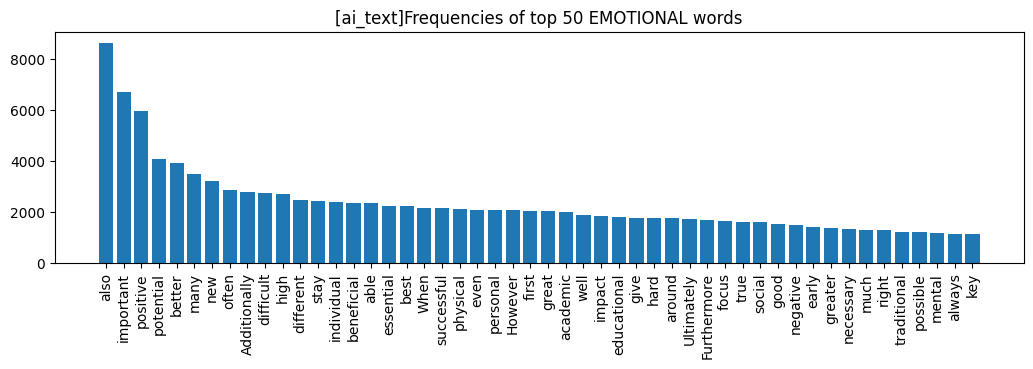

[human_text]PROGRESS: 10000 / 10000
All Done.


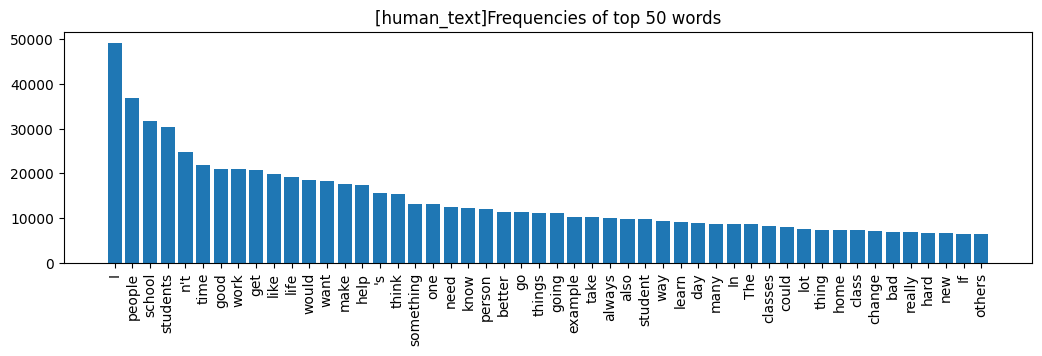

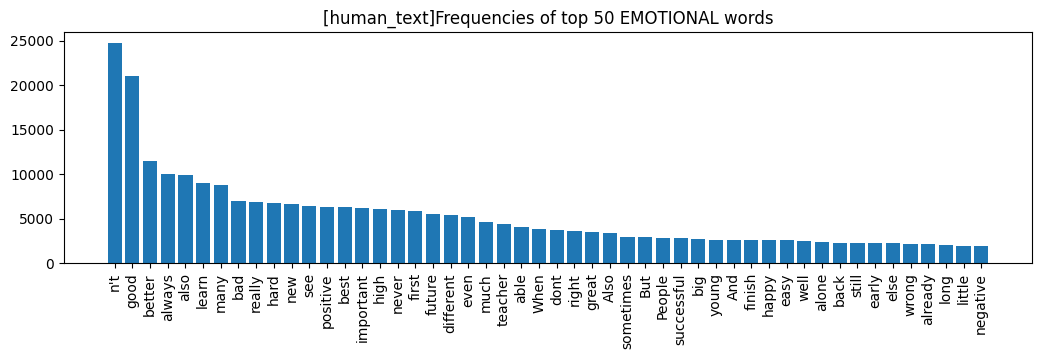

In [8]:
freq_mp = {}

for col in ["ai_text", "human_text"]:
    freqs, emote_freqs = analyze(col, df_sample[col])

    freq_mp[col] = {
        "normal" : freqs,
        "emote" : emote_freqs
    }

In [9]:
classifier = pipeline(
    "zero-shot-classification", model="facebook/bart-large-mnli", device_map="auto"
)

Device set to use cuda:0


In [10]:
def clean_word(input_word: str):

  puncs = set(string.punctuation)

  ret = copy.deepcopy(input_word)

  for p in puncs:

    ret = ret.replace(p,'')

  return ret.strip().lower()


def filter_short(words: List[str]):

  return list(set([clean_word(w) for w in words if len(clean_word(w)) > 1]))

ai_tags = filter_short(freq_mp["ai_text"]["emote"])[:30]
human_tags = filter_short(freq_mp["human_text"]["emote"])[:30]

combined_tags = list(sorted(set(ai_tags + human_tags)))[:30]

In [11]:
combined_tags

['7eleven',
 'aceppt',
 'ansd',
 'approve',
 'cherish',
 'companie',
 'concecuently',
 'conquer',
 'consult',
 'daily',
 'deperested',
 'dicover',
 'dough',
 'embedded',
 'evenly',
 'exigent',
 'fmaily',
 'forever',
 'gadgetenabled',
 'hangry',
 'highest',
 'impartial',
 'inject',
 'just',
 'laborreducing',
 'laughter',
 'lightningfast',
 'litter',
 'markedly',
 'multifaceted']

In [12]:
class AiData(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df["ai_text"].tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [16]:
idx = 0
n_entries = 100
label_rows = []
h_batch_size = 128
diff = 0

sample_sm = df.sample(n_entries)
data = AiData(sample_sm)

for r in classifier(data, combined_tags, batch_size=h_batch_size):

    print(f"\rPROGRESS: {idx + 1} / {n_entries}", end="")
    row = [r["sequence"]]

    for c in combined_tags:
        row.append(r["scores"][r["labels"].index(c)])

    label_rows.append(row)
    idx += 1

    # Purge cache once in a while
    if idx - diff > h_batch_size * 8:
        torch.cuda.empty_cache()
        diff = idx


df_labels = pd.DataFrame(label_rows, columns=["ai_text"] + combined_tags)
df_labels.to_csv(f"labels.csv", index=False)

PROGRESS: 100 / 100

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

NameError: name 'df_labels' is not defined